<a href="https://colab.research.google.com/github/BlackPuma075/Advanced_Lab_2025/blob/main/Final%20Project/Final_Project_Advanced_Lab_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Matter Power Spectrum Catalog**

-Class computation of the spectra

-Variation on $\Omega_m$ only

-100 spectra catalog

In [3]:
import numpy as np
import matplotlib.pyplot as plt

In [4]:
!apt-get install -y gfortran
!git clone https://github.com/lesgourg/class_public.git
%cd class_public
!make

# Volver al directorio base
%cd python
!python3 setup.py install

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
gfortran is already the newest version (4:11.2.0-1ubuntu1).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.
Cloning into 'class_public'...
remote: Enumerating objects: 31195, done.
remote: Total 31195 (delta 0), reused 0 (delta 0), pack-reused 31195 (from 2)
Receiving objects: 100% (31195/31195), 772.26 MiB | 24.59 MiB/s, done.
Resolving deltas: 100% (21623/21623), done.
/content/class_public
if ! [ -e /content/class_public/build ]; then mkdir /content/class_public/build ; mkdir /content/class_public/build/lib; fi;
touch build/.base
cd /content/class_public/build;gcc -O3 -pthread  -g -fPIC -D__CLASSDIR__='"/content/class_public"' -DHYREC -I../include -I../external/RecfastCLASS -I../external/heating -I../external/HyRec2020 -I../external/Halofit -I../external/HMcode -c ../tools/growTable.c -o growTable.o
cd /content/class_public/build;gcc -O3 -pthread  -g -fPIC -D__CLASSDIR__=

In [5]:
from classy import Class

cosmo = Class()
cosmo.set({
    'h': 0.67,
    'omega_b': 0.022,
    'omega_cdm': 0.12,
    'A_s': 2.1e-9,
    'n_s': 0.96,
    'tau_reio': 0.06,
    'output': 'mPk',
    'P_k_max_1/Mpc': 10.0
})
cosmo.compute()

# Obtener espectro de potencia a z = 0
k_vals = [0.01, 0.1, 0.5]
for k in k_vals:
    print(f"P(k={k}) = {cosmo.pk(k, 0.0)}")

ks = np.logspace(-3, 1, 100)  # de 0.001 a 10 h/Mpc
Pk = [cosmo.pk(k, 0.0) for k in ks]

cosmo.struct_cleanup()
cosmo.empty()


P(k=0.01) = 81965.42474078349
P(k=0.1) = 10810.547181012911
P(k=0.5) = 447.1477181056167


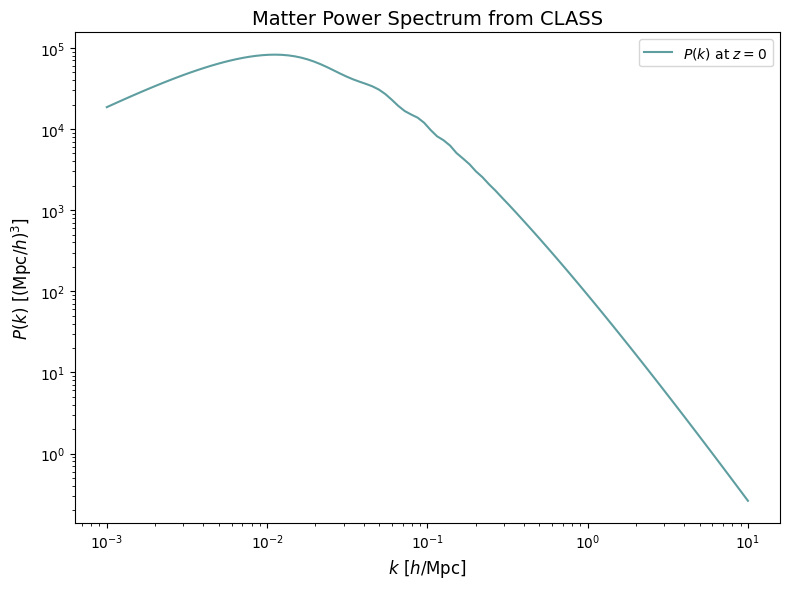

In [6]:
plt.figure(figsize=(8, 6))
plt.loglog(ks, Pk, label=r'$P(k)$ at $z=0$', color='cadetblue')
plt.xlabel(r'$k\ [h/\mathrm{Mpc}]$', fontsize=12)
plt.ylabel(r'$P(k)\ [(\mathrm{Mpc}/h)^3]$', fontsize=12)
plt.title('Matter Power Spectrum from CLASS', fontsize=14)
#plt.grid(True, which="both", ls="--", lw=0.5)
plt.legend()
plt.tight_layout()
plt.show()

**Code snippet to create a catalog of 100 spectra**

In [7]:
%%time
import numpy as np
from classy import Class
import matplotlib.pyplot as plt

# Valores fijos
h = 0.67
omega_b = 0.022
A_s = 2.1e-9
n_s = 0.96
tau = 0.06
z = 0.0
ks = np.logspace(-3, 1, 100)  #100 puntos entre 0.001 y 10 h/Mpc

#Rango de valores de Omega_m
Omega_m_vals = np.linspace(0.2, 0.4, 100)  # 100 valores entre 0.2 y 0.4

#Lista para almacenar los espectros
spectra = []

for Omega_m in Omega_m_vals:
    #Calcular omega_cdm necesario para ese Omega_m
    omega_cdm = Omega_m * h**2 - omega_b

    #Cosmología
    cosmo = Class()
    cosmo.set({
        'h': h,
        'omega_b': omega_b,
        'omega_cdm': omega_cdm,
        'A_s': A_s,
        'n_s': n_s,
        'tau_reio': tau,
        'output': 'mPk',
        'P_k_max_1/Mpc': 10.0
    })

    #Calcular espectro
    cosmo.compute()
    Pk = [cosmo.pk(k, z) for k in ks]
    spectra.append(Pk)

    cosmo.struct_cleanup()
    cosmo.empty()

#'spectra' es una lista de 100 espectros con 100 valores de k cada uno


CPU times: user 2min 57s, sys: 2.36 s, total: 3min
Wall time: 1min 59s


Time of execution: 00:01:03

**Neural Network**

-Imports

-Architechture

-Accuracy

In [8]:
#Imports
import glob
import numpy as np
import copy
import matplotlib.pyplot as plt
import h5py
import scipy
from PIL import Image
from scipy import ndimage
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing

In [9]:
Pks = np.array(spectra) #NN inputs
Omm_labels = Omega_m_vals #NN targets

In [110]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(Pks, Omm_labels, test_size=0.2, shuffle=True, random_state=1) #Random state to get the same shuffle every time

In [111]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape #Data shapes are already (nfeatures, nsamples)

((80, 100), (20, 100), (80,), (20,))

In [103]:
#Normalization (Necessary?)
#scaler=preprocessing.StandardScaler().fit(X_train)
#X_scaled = scaler.transform(X_train)
#X_scaled.shape

(20, 100)

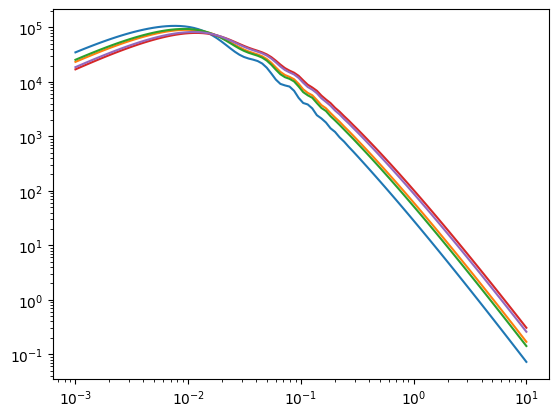

In [112]:
#Variation in Pk's as Omm varies (Shuffle works)
plt.loglog(ks, X_train[0])
plt.loglog(ks, X_train[5])
plt.loglog(ks, X_train[7])
plt.loglog(ks,X_train[10])
plt.loglog(ks, X_train[50])

In [41]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout
from sklearn.neural_network import MLPRegressor

In [113]:
#Testing multiple architectures at once
from sklearn.model_selection import GridSearchCV

param_grid = {
    'hidden_layer_sizes': [(50,), (100, 50), (200, 100, 50)],
    'activation': ['relu', 'tanh'],
    'alpha': [1e-4, 1e-3],
    'learning_rate_init': [0.001, 0.01]
}

grid = GridSearchCV(MLPRegressor(max_iter=1000), param_grid, cv=3)
grid.fit(X_train, y_train)

print("Mejor configuración:", grid.best_params_) #Best fit
print("Score en test:", grid.score(X_test, y_test)) #Can be arbitrary worse (negative values)

/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Mejor configuración: {'activation': 'tanh', 'alpha': 0.001, 'hidden_layer_sizes': (200, 100, 50), 'learning_rate_init': 0.001}
Score en test: -0.298019314088976


In [114]:
model = MLPRegressor(
    hidden_layer_sizes=(200, 100, 50),  #Arquitectura: 3 capas ocultas con 200, 100 y 50 neuronas
    activation='tanh',             #Función de activación: 'relu', 'tanh', 'logistic'
    solver='adam',                 #Algoritmo de optimización: 'adam', 'sgd', 'lbfgs'
    alpha=1e-4,                    #Regularización (L2 penalty)
    learning_rate_init=0.001,      #Tasa de aprendizaje inicial
    max_iter=1000,                 #Número máximo de épocas
    random_state=42
)
model.fit(X_train,y_train)

#model.predict(X_test[:2])
model.score(X_test, y_test)

0.7942868784235445

In [133]:
print('Prediction: ',model.predict(X_test[4:5]),'True value: ',y_test[4])

Prediction:  [0.3506294] True value:  0.3878787878787879


In [140]:
#Testing multiple architectures at once
from sklearn.model_selection import GridSearchCV

param_grid = {
    'hidden_layer_sizes': [(200, 100, 50), (150, 150, 50)],
    'activation': ['tanh'],
    'alpha': [1e-4, 1e-3],
    'learning_rate_init': [0.001, 0.01]
}

grid = GridSearchCV(MLPRegressor(max_iter=1000), param_grid, cv=3)
grid.fit(X_train, y_train)

print("Mejor configuración:", grid.best_params_) #Best fit
print("Score en test:", grid.score(X_test, y_test)) #Can be arbitrary worse (negative values)

Mejor configuración: {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (150, 150, 50), 'learning_rate_init': 0.001}
Score en test: 0.356952371556741


**Probé varias aqruitecturas no funcionó, al igual que modificar el tamaño del dataset. Tampoco cambiar el límite del número de onda mejoró la precisión.**

In [153]:
model2 = MLPRegressor(
    hidden_layer_sizes=(200, 100, 50),  #Arquitectura: 3 capas ocultas con 200, 100 y 50 neuronas
    activation='tanh',             #Función de activación: 'relu', 'tanh', 'logistic'
    solver='lbfgs',                 #Algoritmo de optimización: 'adam', 'sgd', 'lbfgs'
    alpha=1e-4,                    #Regularización (L2 penalty)
    learning_rate_init=0.001,      #Tasa de aprendizaje inicial
    max_iter=1000,                 #Número máximo de épocas
    random_state=42
)
model2.fit(X_train,y_train)

#model.predict(X_test[:2])
model2.score(X_test, y_test)

0.9861288452370174

**Cambiar el solver de 'adam' a 'lbgfs' mejora mucho la precisión a 98.6%**

Eso resuelve el problema del tamaño del dataset ya que el lbfgs solver está diseñado para datasets más compactos.

In [151]:
print('Prediction: ',model2.predict(X_test[5:6]),'True value: ',y_test[5])

Prediction:  [0.23373653] True value:  0.23434343434343435
